In [1]:
import sys
sys.path.append("/Users/sam/All-Program/App/ObjectDetection/")

import numpy as np
from MaskRCNN.config import config 

## Generate a config 

In [2]:
class ShapesConfig(config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    IMAGE_SHAPE = [128, 128, 3]

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
conf = ShapesConfig()
conf.display()


Configurations:
BATCH_NORM_DECAY                         0.9
BBOX_STD_DEV                             [ 0.1  0.1  0.2  0.2]
DETECTION_MIN_THRESHOLD                  0.7
DETECTION_NMS_THRESHOLD                  0.3
DETECTION_POST_NMS_INSTANCES             100
GPU_COUNT                                1
IMAGES_PER_GPU                           8
IMAGE_MAX_DIM                            128
IMAGE_MIN_DIM                            128
IMAGE_MIN_SCALE                          0
IMAGE_RESIZE_MODE                        square
IMAGE_SHAPE                              [128, 128, 3]
MEAN_PIXEL                               [ 123.7  116.8  103.9]
NAME                                     shapes
NUM_CLASSES                              4
POST_NMS_ROIS_INFERENCE                  1000
POST_NMS_ROIS_TRAINING                   2000
PRE_NMS_ROIS_INFERENCE                   6000
RESNET_STRIDES                           [4, 8, 16, 32, 64]
RPN_ANCHOR_RATIOS                        [0.5, 1, 2]
RPN_ANCHOR_S

## Generate Random Images, Squares traingle and circle.

In [3]:
import random
import cv2
import math
import numpy as np
from MaskRCNN.building_blocks import utils


class Dataset():
    def __init__(self, num_images, height, width, num_classes):
        self.image_meta = {}
        self.num_classes = num_classes
        self.class_names = dict(square=0, triangle=1, circle=2)
        
        for i in range(0, num_images):
            self.image_meta[i] = self.build_images_meta(height, width)
    
    def draw_bg_image(self, height, width, bg_color):
        bg_ = np.array(bg_color).reshape([1, 1, 3])
        bg_image = np.ones([height, width, 3]) * np.array(bg_, dtype=np.uint8)
        return bg_image
    
    def draw_object_shape(self, image, object_, color, dims):
        ''' WHY THE WEIRDNESS IN FORMULA

        :param bg_image:
        :param object_info:
        :return:

        Important Note: When you look at the formulas, it might seem weird or rather oposite to what we are
        accustomed to use with numpy. This is because, we use OpenCV.

        Numpy          0,10 ____________ 10,10
                            |          |
                            |          |
                            |          |
                       0,0  |__________| 10,0

        OpenCV         0,0  ____________ 10,0
                            |          |
                            |          |
                            |          |
                       0,10 |__________| 10,10

        '''
        c_y, c_x, size = dims
        if object_ == 'square':
            cv2.rectangle(image, (c_x - size, c_y - size), (c_x + size, c_y + size), color, -1)
        elif object_ == 'circle':
            cv2.circle(img=image, center=(c_x, c_y), radius=size, color=color, thickness=-1)
        elif object_ == 'triangle':
            points = np.array([[(c_x, c_y - size),  # Top point
                                (c_x - size / math.sin(math.radians(60)), c_y + size),  # Bottom left
                                (c_x + size / math.sin(math.radians(60)), c_y + size),  # Bottom right
                                ]], dtype=np.int32)
            
            cv2.fillPoly(image, points, color)
        return image
    
    def gen_random_shapes(self, height, width):
        # select a random object (class)
        object_ = np.random.choice(['square', 'triangle', 'circle'])
        
        # Get random color for 3 channels
        color = tuple([random.randint(0, 255) for _ in range(3)])
        
        # Leave a buffer space (pad) of 20 pixels for the object_ to accomodate in the
        # background and collect a random center points (c_x, cy)
        buffer_space = 20
        c_y = np.random.randint(buffer_space, height - buffer_space - 1)
        c_x = np.random.randint(buffer_space, width - buffer_space - 1)
        
        # Get a Random size of the bounding box in which the object_ (tringle, square, cicle) is embedded
        size = np.random.randint(buffer_space, height // 4)
        # to account for both side towards the left form center to the right
        return object_, color, (c_y, c_x, size)
    
    def gen_random_image(self, height, width):
        # Pick a random 3 channel for the background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        
        # Pick randomly how many object_ to put in the background image frame
        num_objects = np.random.randint(1, self.num_classes)
        
        object_info = []
        bounding_boxes = []
        for _ in range(0, num_objects):
            object_, color, (c_y, c_x, size) = self.gen_random_shapes(height, width)
            object_info.append((object_, (color), (c_y, c_x, size)))
            bounding_boxes.append(
                    [c_y - size, c_x - size, c_y + size, c_x + size]
            )  # lower left and upper right coordinates
        bounding_boxes = np.array(bounding_boxes)
        # print(bounding_boxes)
        # Sometimes if we select two or more objects to be dispayed in the image we can have those images
        # to overlap completely. In such a case we should ensure that the non-max supression between the
        # objects are atleast 0.3 so that we dont mess out training labels.
        keep_idx = utils.non_max_supression(bounding_boxes, np.arange(num_objects), threshold=0.3)
        # print('object_info pre NMS ', object_info)
        object_info = [s for i, s in enumerate(object_info) if i in keep_idx]
        # print('keep_idx ', keep_idx)
        # print('objects post NMS ', object_info)
        return bg_color, object_info
    
    def build_images_meta(self, height, width):
        image_info = {}
        image_info['height'] = height
        image_info['width'] = width
        bg_color, object_info = self.gen_random_image(height, width)
        image_info['object_info'] = object_info
        image_info['bg_color'] = bg_color
        return image_info
    
    def get_object_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID. 

        Its the same shape as that of the image, however only the object part is colored white
        output_shape = [height, width, num_objects], where 

        """
        image_info = self.image_meta[image_id]
        object_info = image_info['object_info']
        object_cnt = len(object_info)
        mask = np.zeros([image_info['height'], image_info['width'], object_cnt], dtype=np.uint8)
        for i, (object_, _, dims) in enumerate(object_info):
            mask[:, :, i:i + 1] = self.draw_object_shape(mask[:, :, i:i + 1].copy(), object_, 1, dims)
        
        # Handle occlusions, when two objects intersect, we should ensure that the intersection mask is
        # given to only only object.
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        # print(occlusion)
    
        for i in range(object_cnt-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        return mask.astype(np.bool)

    def get_class_labels(self, image_id):
        object_info = self.image_meta[image_id]["object_info"]
        # Map class names to class IDs.
        class_ids = np.array([self.class_names[s[0]] for s in object_info])
        return class_ids.astype(np.int32)

    def get_image(self, image_id):
        image_info = self.image_meta[image_id]
        object_info = image_info['object_info']
        bg_color = image_info['bg_color']
        height = image_info['height']
        width = image_info['width']
        image = self.draw_bg_image(height, width, bg_color)
        # print(object_info)
        num_objects = len(object_info)
        
        for i in np.arange(num_objects):
            object_, color, dims = object_info[i]
            image = self.draw_object_shape(image, object_, color, dims)
        return image

## Visualize the Image, Objects and masks:

In [4]:
data = Dataset(num_images=5, height=128, width=128, num_classes=4)
image_ids = data.image_meta.keys()

images = []
masks = []
class_ids = []
for ids in image_ids:
    images.append(data.get_image(image_id=ids))
    masks.append(data.get_object_mask(image_id=ids))
    class_ids.append(data.get_class_labels(image_id=ids))

In [5]:
masks[0][:,:,0].shape

(128, 128)

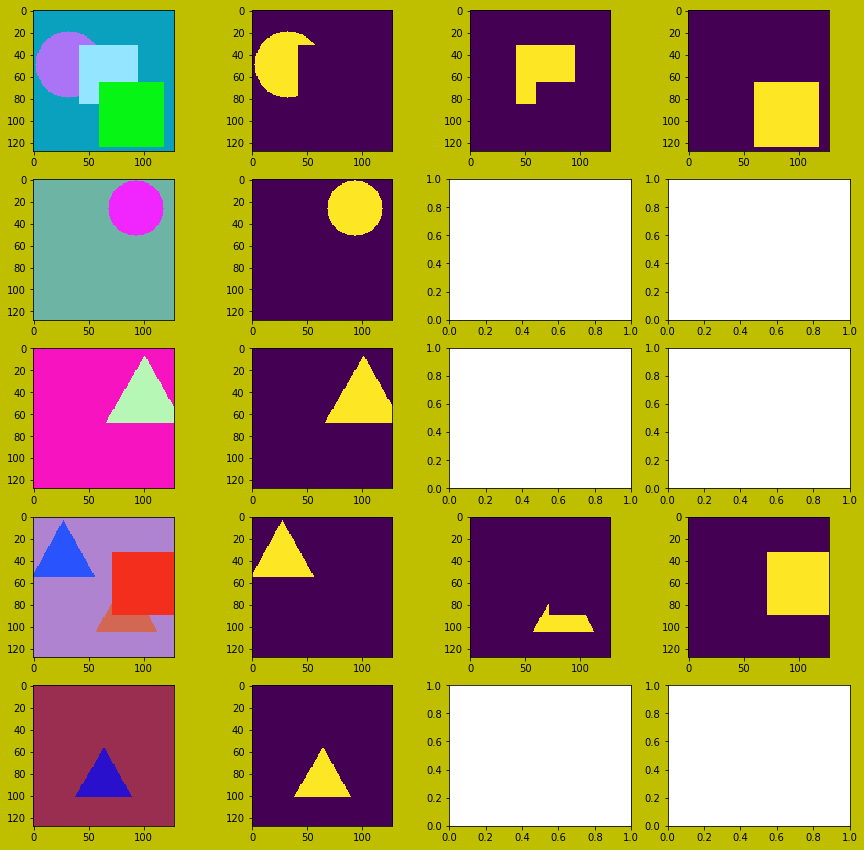

In [6]:
from MaskRCNN.visualize import Visualize
obj_viz = Visualize(rows=5, cols=4, figsize=(15,15))

for i in range(0,len(images)):
    obj_viz.vizualize_image(images[i])
    for j in range(0,3):
        if j < masks[i].shape[2]:
            obj_viz.vizualize_image(masks[i][:,:,j])
        else:
            obj_viz.num += 1
obj_viz.show()

## Prepare Data For Training:

In [7]:
# from MaskRCNN.building_blocks.data_processor import PreprareTrainData
# class_ids = [0,1]


# Keep metadata of images for post processing
def compose_image_meta(image_id, original_image_shape, image_shape,
                       img_window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    original_image_shape: [H, W, C] before resizing or padding.
    image_shape: [H, W, C] after resizing and padding
    img_window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    scale: The scaling factor applied to the original image (float32)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(img_window) +                # size=4 (y1, x1, y2, x2) in image coordinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta


class PreprareTrainData():
    def __init__(self, conf):
        self.image_min_dim = conf.IMAGE_MIN_DIM
        self.image_max_dim = conf.IMAGE_MAX_DIM
        self.min_scale = conf.IMAGE_MIN_SCALE
        self.resize_mode = conf.IMAGE_RESIZE_MODE
    
    def extract_bboxes(self, mask):
        '''
        :param mask: [height, width, num_objects]
        :return:     Given a mask outputs a bounding box with "lower left" and "upper right" coordinites
        '''
        bboxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
        shift = [0, 0, 1, 1]
        for i in range(0, mask.shape[-1]):
            msk = mask[:, :, i]
            horizontal_coord = np.where(np.any(msk, axis=0))[0]
            vertical_coord = np.where(np.any(msk, axis=1))[0]
            
            if len(horizontal_coord) >= 0 and len(horizontal_coord) >= 0:
                x1, x2 = horizontal_coord[[0, -1]]
                y1, y2 = vertical_coord[[0, -1]]
                
                bbox = np.array([y1, x1, y2, x2]) + shift
            else:
                bbox = [0, 0, 0, 0]
            bboxes[i] = bbox
        return bboxes.astype(np.int32)
    
    def get_ground_truth_data(self, dataset, image_ids):
        images = []
        gt_masks = []
        gt_class_ids = []
        gt_bboxes = []
        image_meta = []
        for ids in image_ids:
            image = dataset.get_image(image_id=ids)
            mask = dataset.get_object_mask(image_id=ids)
            class_ids = dataset.get_class_labels(image_id=ids)
            active_class_ids = np.zeros(dataset.num_classes, dtype=np.int32)
            active_class_ids[class_ids] = 1
            original_image_shape = image.shape
            
            image, image_window, scale, padding = utils.resize_image(image, min_dim=self.image_min_dim,
                                                                     max_dim=self.image_max_dim,
                                                                     min_scale=self.min_scale,
                                                                     mode=self.resize_mode)
            mask = utils.resize_mask(mask, scale, padding)
            bboxes = self.extract_bboxes(mask)
            
            
            image_meta.append(compose_image_meta(ids, original_image_shape, image.shape,
                                                 image_window, scale, active_class_ids))
            images.append(image)
            gt_masks.append(mask)
            gt_class_ids.append(class_ids)
            gt_bboxes.append(bboxes)
        
        images = np.stack(images, axis=0)
        return images, gt_masks, gt_class_ids, gt_bboxes, image_meta


In [9]:

obj_ptd = PreprareTrainData(conf)
images, gt_masks, gt_class_ids, gt_bboxes, image_meta = obj_ptd.get_ground_truth_data(data, image_ids)
print(image_meta)

[array([  0, 128, 128,   3, 128, 128,   3,   0,   0, 128, 128,   1,   1,
         0,   1,   0]), array([  1, 128, 128,   3, 128, 128,   3,   0,   0, 128, 128,   1,   0,
         0,   1,   0]), array([  2, 128, 128,   3, 128, 128,   3,   0,   0, 128, 128,   1,   0,
         1,   0,   0]), array([  3, 128, 128,   3, 128, 128,   3,   0,   0, 128, 128,   1,   1,
         1,   0,   0]), array([  4, 128, 128,   3, 128, 128,   3,   0,   0, 128, 128,   1,   0,
         1,   0,   0])]


In [ ]:
np.sum(gt_masks[0], axis=(0, 1))

In [ ]:
np.sum(np.transpose(gt_masks[0], axes=[2,0,1]), axis=(1,2))

In [ ]:
np.transpose(gt_masks[0], axes=[2,0,1]).shape

#### Cross check, If the data was generated properly

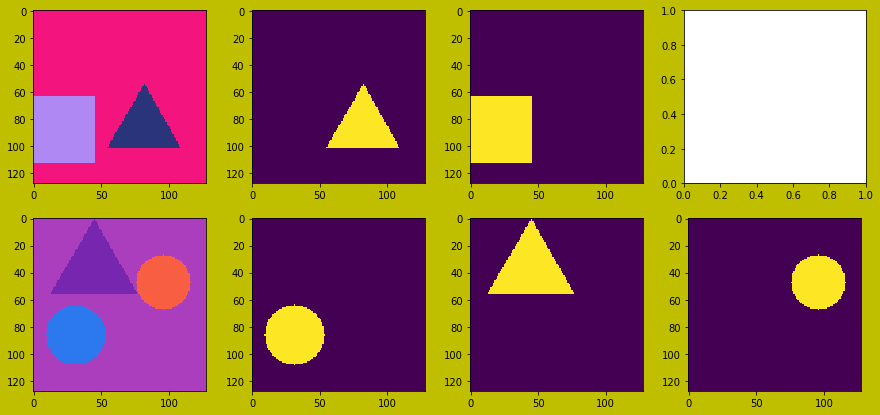

In [15]:
from MaskRCNN.visualize import Visualize
obj_viz = Visualize(rows=2, cols=4, figsize=(15,7))

for i in range(0,len(images)):
    obj_viz.vizualize_image(images[i])
    for j in range(0,3):
        if j < gt_masks[i].shape[2]:
            obj_viz.vizualize_image(gt_masks[i][:,:,j])
        else:
            obj_viz.num += 1
obj_viz.show()

## TO DOS:

-- We have background color and class ids that have been selected to be in the image
-- We need to
    * generate masks for image
    * resize image  # Already wrote the function for this
    * resize masks, # Since we resize the image, we need to resize the mask
    * Do image augmentation (Horizontal flip), remember to flip the masks too. (Keep it simple: Dont do it for now)
    * make a data generation function, that can do stuff on the fly

## INPUTS:

For Proposals
1. Input anchors
--> Run FPN, RPN, Proposals. get proposals

For Detection module:
2. input_gt_boxes: Input ground_truth boxes: (normalize these boxes -> gt_boxes)
3. input_gt_masks: Input ground_truth mask
4. input_gt_class_ids: Input ground_truth_class_ids
5. target_rois or proposals


4. active_class_ids


### Code flow:
* data_generator: generates the data given the input
    * compute_backbbone_shape:  Wrote already
    * generate_pyramid_anchors: Already worte
    * load_image_gt
    



In [7]:
from MaskRCNN.building_blocks import utils
from MaskRCNN.config import config as conf

utils.get_resnet_stage_shapes(conf, [128,128,3])

array([[32, 32],
       [16, 16],
       [ 8,  8],
       [ 4,  4],
       [ 2,  2]])

In [37]:
imageIN = data.get_images(0)#
print (imageIN.shape)
maskIN = data.get_object_mask(0)
print (maskIN.shape)

(128, 128, 3)
(128, 128, 2)


In [38]:
image_t, image_window, scale, padding = utils.resize_image(imageIN, max_dim=256, min_dim=256, min_scale=1)

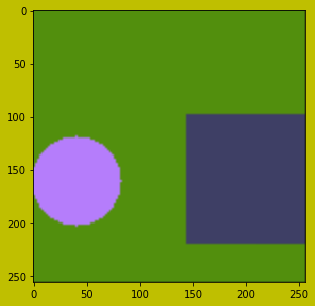

In [39]:
obj_v = Visualize()#
obj_v.vizualize_image(image_t)#
obj_v.show()

In [40]:
print(scale)
print(padding)

2.0
[(0, 0), (0, 0), (0, 0)]


In [41]:
maskIN_ = np.transpose(maskIN, [2,0,1])
maskIN_.shape

(2, 128, 128)

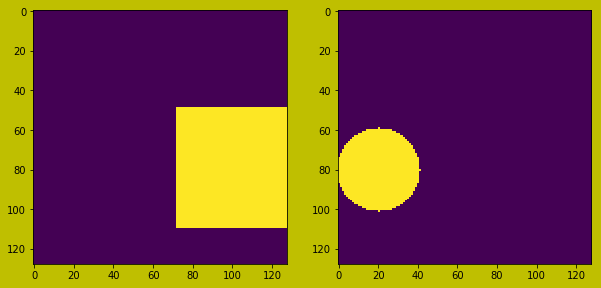

In [42]:
obj_v = Visualize(rows=1, cols=2, figsize=(10,5))
obj_v.visualize_image_2d(maskIN_)#
obj_v.show()

In [44]:
mask_zoom = scipy.ndimage.zoom(maskIN, zoom=[1, 1, 1], order=0)
print (mask_zoom.shape)

(128, 128, 2)


In [46]:
m = mask_zoom[:,:,1]

horizontal_indices = np.where(np.any(m, axis=0))[0]
vertical_indices = np.where(np.any(m, axis=1))[0]
print (len(horizontal_indices), horizontal_indices)
print (len(vertical_indices), vertical_indices)

42 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
43 [ 59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101]


In [34]:
horizontal_indicies[[0, -1]]

array([ 57, 101])

In [22]:
np.array([[1],[1],[0],[-1],[-1]]).shape

(5, 1)

In [30]:
import keras.layers as KL
import keras.backend as K
import numpy as np
import tensorflow as tf
tf.reset_default_graph()
input_rpn_match = tf.constant(np.array([[[1],[1],[0],[-1],[-1]]]), dtype=tf.float32)
rpn_class_logits = tf.constant(np.random.random((1,5,2)), dtype=tf.float32)


def rpn_class_loss_graph(rpn_match, rpn_class_logits):
    """RPN anchor classifier loss.

    rpn_match: [batch, anchors, 1]. Anchor match type. 1=positive,
               -1=negative, 0=neutral anchor.
    rpn_class_logits: [batch, anchors, 2]. RPN classifier logits for FG/BG.
    """
    print('RUNNING rpn_class_loss_graph ......................')
    # Squeeze last dim to simplify
#     print (rpn_match.shape)
    rpn_match = tf.squeeze(rpn_match, -1)
#     Get anchor classes. Convert the -1/+1 match to 0/1 values.
    anchor_class = K.cast(K.equal(rpn_match, 1), tf.int32)
    # Positive and Negative anchors contribute to the loss,
    # but neutral anchors (match value = 0) don't.
    indices = tf.where(K.not_equal(rpn_match, 0))
    # Pick rows that contribute to the loss and filter out the rest.
    rpn_class_logits = tf.gather_nd(rpn_class_logits, indices)
    anchor_class = tf.gather_nd(anchor_class, indices)
    # Crossentropy loss
    loss = K.sparse_categorical_crossentropy(target=anchor_class,
                                             output=rpn_class_logits,
                                             from_logits=True)
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    return anchor_class

rpn_class_loss = KL.Lambda(lambda x: rpn_class_loss_graph(*x), name="rpn_class_loss")(
                [input_rpn_match, rpn_class_logits])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    a= sess.run([rpn_class_loss])
    print(a)



RUNNING rpn_class_loss_graph ......................
RUNNING rpn_class_loss_graph ......................
[array([1, 1, 0, 0], dtype=int32)]


In [42]:
a = tf.constant([1.0,2.0,3.0,4.0])
aa = tf.constant([5.0,6.0,3.0,4.0])
l1_dist = tf.abs(a - aa)
b = tf.reduce_sum(a)
c = tf.cast(tf.less(l1_dist,1.0), tf.float32)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(b))
    print(sess.run(l1_dist))
    print(sess.run(c))

10.0
[ 4.  4.  0.  0.]
[ 0.  0.  1.  1.]
